In [9]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from minisom import MiniSom
from shapely.geometry import Point
import geopandas as gpd
from region_details import get_region_details



Needed input files:
- River discharge: EFAS historical daily or 6 hourly, within the basin from pre-process-watershed.ipynb (Option for development: pre-processing can be integrated here.)
- Precipitation data (EMO1)
- MSLP/Z500 circulation data (ERA5)

CONTROL PARAMETERS
- Definition of hazard: single grid point discharge, maximum-basin discharge, economic (to be integrated)
- Criteria (??) for most intense events selection for SOM clustering
- Note: an option could also be to only select top 10 events here, and  then do the clustering sesaonal forecasts only.)

OUTPUT:
- Fig 1: Full timeseries of river discharge and subpanel with one year with the largest discharge event
- Fig 2: Spatial map of discharge during largest event
- Fig 3: Mean seasonal cycle of mean river discharge and monthly-maxima extremes. For each month, we compute percentiles across the years. e.g. 50th percentile, 90th percentile, maximum
- Fig 4: Determining the most correlated precip accumulation length and lag, and the strength of the correlation. High -> single storm events. Weak -> events have a compound nature. 
- Fig 5: Return period curve

QUESTIONS:
- Meteorological forcing could develop over multiple days. How to define the relevant meteorological pattern?
- If there is a strong contribution from snow melting, meteorological driving can be weak/varied
- Defining the number of events: depening on the autocorrelation of discharge, percentile-defined threshold will lead to a different number of events
- How to treat single forcing, vs compound events.
- Averaging of precipitation in watershed really slow! Consider saving mask and multiply with cdo or within numpy. 


In [ ]:
# SORT OF USER CONFIGURATION
EFASDIR_HIST="/home/zappa/work_big/EFAS"

# Name Pattern of EFAS data, * reflects different years
watershed='panaro'
tres='day'
#
# path of efas data masked for watershed
wshed_fname=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/efas_{watershed}_masked.nc"  # from preprocessed file

# path of maximum discharge in watershed
wshed_dismax_fname=os.path.dirname(wshed_fname)+f"/basinmax/efas_{watershed}.nc"

# directory of HydroBasins shapefile
shape_dir="/work_big/users/zappa/TRANSLATE/HydroBasins/hybas_lake_eu_lev01-12_v1c/"


# variable name in EFAS file
if tres=='day':
    disname='dis24'
elif tres=='6h':
    disname='dis06'

# starting and last year to be analysed (EFAS historical)
sy=1992
ly=2023

# region details
winfo=get_region_details(watershed)
tlon=winfo['tlon']
tlat=winfo['tlat']
tlabel=winfo['tlabel']
hblevel=winfo['shape_file_level']
bbox=winfo['bounding_box'] # lonS, latW, lonN, latE
#atmbox=winfo['era_box'] 

# watershed central point
wspoint = Point(tlon, tlat)

# temporary output EFAS timeseries at single point
fname_gp=f"{EFASDIR_HIST}/postpro/{tres}/single_gp/efas_{watershed}_{tlabel}_{tres}.nc"

# FLAGS
plot2d_day=True
ReadExisting=True  # True: reads any preprocessed data written to disk. False: EFAS data is read from the netcdf files
HazardDef="wmax"   # gridpoint (gp), watershed max (wmax), economic (eco). gp is based on tlon,tlat. 

# path to directory with figures
figdir=f"/home/zappa/TRANSLATE/figures/{watershed}/{tres}/"
os.makedirs(figdir, exist_ok=True)


# Reading watershed

<Axes: >

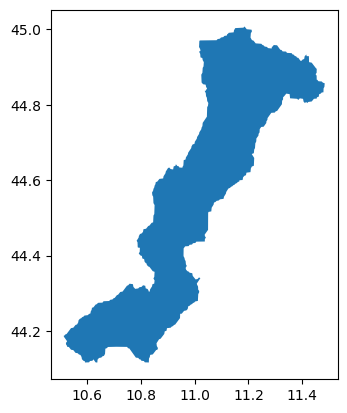

In [11]:
# read watershed shapefiles
def read_watershed_shapefiles(shape_dir, level, wspoint):
    """
    Read watershed shapefiles and extract the shapefile entry that contains a specific point.

    Parameters:
    shape_dir (str): The directory where the shapefiles are located.
    level (str): The level of the shapefiles to read.
    wspoint (Point): The point to analyze.

    Returns:
    GeoDataFrame: A GeoDataFrame containing the shapefile entry that contains the point.
    """
    # Construct the shapefile path
    shapef_path = os.path.join(shape_dir, f"hybas_lake_eu_lev{level}_v1c.shp")

    # Read the shapefile
    shape_gdf = gpd.read_file(shapef_path)

    # Find the shapefile entries that contain the point
    contains_point = shape_gdf['geometry'].contains(wspoint)

    # Extract the shapefile entry that contains the point
    shape_basin_gdf = shape_gdf[contains_point]

    return shape_basin_gdf


def xarray_in_shapefile(xds,varname,latname,lonname,shapef,operation):
    
    # compute average precipitation (ds_emo) for grid points within shape_basin_gdf
    df = xds[varname].to_dataframe()
    lats = df.index.get_level_values(latname)
    lons = df.index.get_level_values(lonname)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lons,lats),crs='EPSG:4326')

    # created join dataframe between data and shapefile
    gdf_joined = gpd.sjoin(gdf, shapef, predicate='within')

     # Group by time and region, and sum the values
    if operation=='mean':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].mean()
    elif operation=='sum':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].sum()
    elif operation=='max':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].max()

    # Convert the series to a DataFrame and pivot it
    results_df=pd.DataFrame()
    results_df[varname] = results.reset_index().pivot(index='time', columns='index_right', values=varname)
    results_xds=results_df.to_xarray()

    return results_df, results_xds

# read shape file
shape_basin_gdf=read_watershed_shapefiles(shape_dir, hblevel, wspoint)
shape_basin_gdf.plot()


### Read and store watershed data, single grid point

In [12]:
# Read EFAS data for single grid point, and save it to .nc for more rapid access in future executions
# It would make sense to have a function that reads the hazard: either as a single grid point, watershed max, or economic
def read_and_store_time_series(fname_pat, lat, lon, output_file, ReadExisting):
        
    """
    Read time series data from a specified grid point and store it on disk.
    
    Parameters:
    fname_pat (str or list of str): File path pattern or list of file paths.
    lat_index (int): Index of the latitude grid point.
    lon_index (int): Index of the longitude grid point.
    output_file (str): Output file name to store the time series data (default: 'time_series_data.nc').
    check_existing (bool): Whether to check if the output file already exists (default: True).
    """
    # Check if the output file already exists
    if ReadExisting and os.path.exists(output_file):
        # If the output file exists, read it straight away
        time_series = xr.open_dataset(output_file)
    else:
        # If the output file does not exist, proceed with extracting data from the dataset
        # Open the multi-file dataset
        dataset = xr.open_mfdataset(fname_pat, combine='by_coords')

        # Extract time series data for the specified grid point
        time_series = dataset.sel(lat=lat,lon=lon,method='nearest')

        # Store the extracted time series data on disk
        time_series.to_netcdf(output_file)
    
    return time_series

# read hazard based on hazard definition
if HazardDef=="gp":
    xds_hazard = read_and_store_time_series(wshed_fname, tlat, tlon, fname_gp, ReadExisting)
elif HazardDef=="wmax":
    # if maximum discharge exists, read it, otherwise compute it
    if os.path.exists(wshed_dismax_fname) and ReadExisting:
        xds_hazard=xr.open_dataset(wshed_dismax_fname)
    else:
        # read EFAS data
        xds=xr.open_mfdataset(wshed_fname,combine='by_coords')
        xds_hazard=xds.max(dim=['lat', 'lon'])

        # save to file
        xds_hazard.to_netcdf(wshed_dismax_fname)

# discharge values (convert to numpy array)
ds_hazard=xds_hazard[disname].values

# Look at time series of streamflow

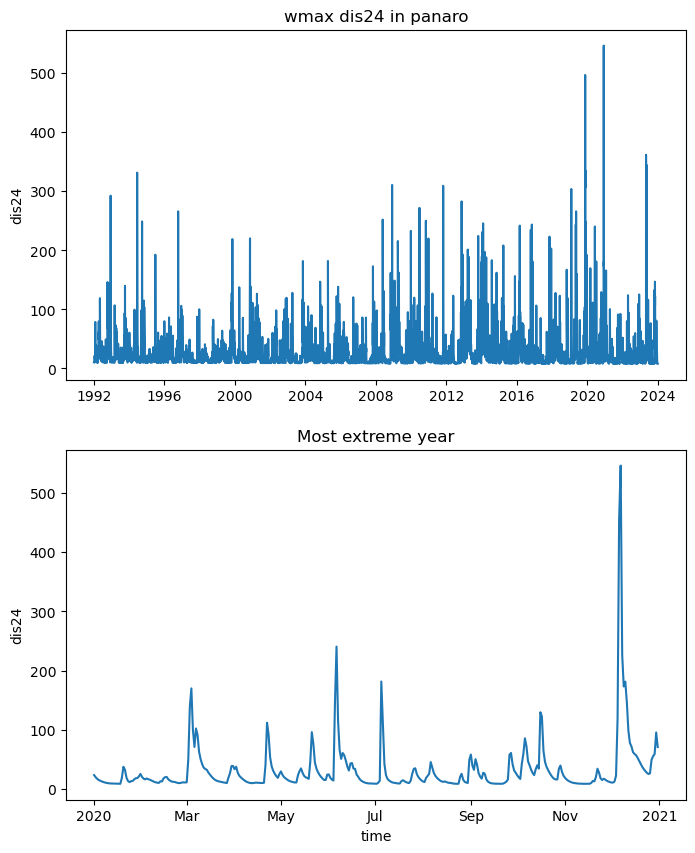

In [13]:

# plot timeseries using xarray 
fig,axs=plt.subplots(2,1,figsize=(8,10))
time_start_plot="1992-01-01"
time_end_plot="2023-12-31"
xds_hazard[disname].sel(time=slice(time_start_plot,time_end_plot)).plot(ax=axs[0])
axs[0].set_title(f"{HazardDef} {disname} in {watershed}")
axs[0].set_xlabel("")

# select year with maximum discharge
max_year1 = xds_hazard[disname].idxmax(dim='time').values
max_year = max_year1.astype('datetime64[Y]').item().year

# set time_start_plot
time_start_plot=f"{max_year}-01-01"
time_end_plot=f"{max_year}-12-31"
xds_hazard[disname].sel(time=slice(time_start_plot,time_end_plot)).plot(ax=axs[1])
axs[1].set_title("Most extreme year")

# save figure
figname=f"{figdir}/{HazardDef}_timeseries.png"
plt.savefig(figname)


# Plot example streamflow map in a given day, with watershed contour

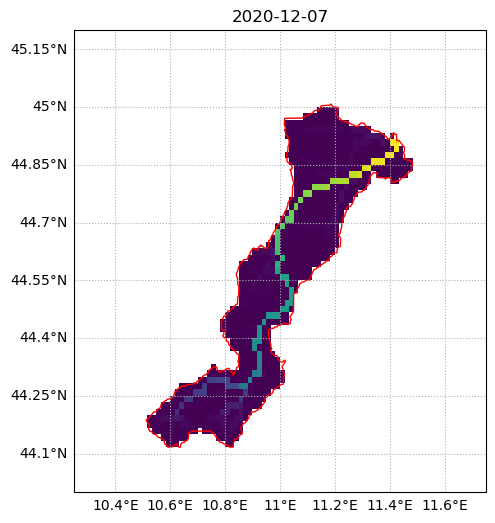

In [14]:
# Plot a map for a day associated with Panaro flooding near Modena
# It would be more efficient if we just read the .nc containing the event (sort by year)
def map_discharge(ax,xdis, timestep,disname,lon_name,lat_name,bbox,shape_basin_gdf):
    data2d_day=xdis.sel(time=timestep)   

    # Extract longitude, latitude, and variable data
    lon, lat, vv = data2d_day[lon_name], data2d_day[lat_name], data2d_day[disname]

    # Plot the variable on the map
    ax.pcolormesh(lon, lat, vv, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.set_xlim(bbox[1], bbox[3])  # Set longitude range
    ax.set_ylim(bbox[0], bbox[2])  # Set latitude range

    # add lon labels
    # ax.set_xticks(np.arange(bbox[1], bbox[3], 0.5))
    # ax.set_xticklabels(np.arange(bbox[1], bbox[3], 0.5), rotation=45)
    # ax.set_yticks(np.arange(bbox[0], bbox[2], 0.5))
    # ax.set_yticklabels(np.arange(bbox[0], bbox[2], 0.5))

    # Add coastlines, gridlines, and title
    ax.coastlines()
    gl=ax.gridlines(draw_labels=True, linestyle=':')
    gl.top_labels = False  # Disable labels at the top
    gl.right_labels = False  # Disable labels on the right

    formatted_time_step = str(timestep)[:10]
    ax.set_title(f'{formatted_time_step}')
    #plt.colorbar(label='discharge')
  
    # plot the watershed
    shape_basin_gdf.plot(ax=ax, color='none', edgecolor='red',transform=ccrs.PlateCarree())


if plot2d_day:   
    ## Plot the map
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    dataset2d = xr.open_mfdataset(wshed_fname, combine='by_coords')
    map_discharge(ax,dataset2d,max_year1,disname,'lon','lat',bbox,shape_basin_gdf)
    
    #save figure
    figname=f"{figdir}/{HazardDef}_map_mostXtreme_event.png"
    plt.savefig(figname)

    plt.show()


### Mean seasonality analyses

In [15]:
# this is not working, yet
def circular_rolling(da, window_size):
    # Append the start of the DataArray to the end to create a circular buffer
    circular_data = np.concatenate([da, da[:window_size]])

    # Create a new DataArray with the circular buffer
    circular_da = xr.DataArray(circular_data, dims=da.dims, coords=da.coords)

    # Apply the rolling operation
    result = circular_da.rolling({da.dims[0]: window_size}, center=True).mean()

    # Slice off the extra values at the end
    result = result[:len(da)]

    return result


In [16]:

# Compute statistics of seasonal cycle and save to file
# check if output exists
window_size = 45  # Smoothing to highlight mean seasonal cycle
percentile_value=50 # percentile of extremes values within 1 week window across years
stats_clim_fname=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/stats/efas_{watershed}_seasonalcycle_win{window_size}_pctx{percentile_value}.nc"
if os.path.exists(stats_clim_fname) and ReadExisting:
    xds_stats_clim=xr.open_dataset(stats_clim_fname)
    # daily_means=xds_stats_clim['daily_means']
    # smoothed_means=xds_stats_clim['smoothed_means']
    # daily_max=xds_stats_clim['daily_max']
    # smoothed_max=xds_stats_clim['smoothed_max']
    # monthly_max_p=xds_stats_clim['week_max_p']
    # smoothed_week_max=xds_stats_clim['smoothed_week_max']
else:
    # mean seasonality
    daily_means = xds_hazard[disname].groupby('time.dayofyear').mean(dim='time')
    daily_max = xds_hazard[disname].groupby('time.dayofyear').max(dim='time')

    week_max = xds_hazard[disname].resample(time='1W').max(dim='time').chunk({'time': -1})
    week_max_p50 = week_max.groupby('time.week').quantile(q=50 / 100, dim='time')
    week_max_p90 = week_max.groupby('time.week').quantile(q=90 / 100, dim='time')
    week_max_max = week_max.groupby('time.week').max(dim='time')

    monthly_max = xds_hazard[disname].resample(time='1M').max(dim='time').chunk({'time': -1})
    monthly_max_p50 = monthly_max.groupby('time.month').quantile(q=50 / 100, dim='time')
    monthly_max_p90 = monthly_max.groupby('time.month').quantile(q=90 / 100, dim='time')
    monthly_max_max = monthly_max.groupby('time.month').max(dim='time')

    # roolling average
    week_size=int(np.round(window_size/7))
    smoothed_means = daily_means.rolling(dayofyear=window_size, center=True).mean()
    smoothed_max = daily_max.rolling(dayofyear=window_size, center=True).mean()

    # save to file
    xds_stats_clim=xr.Dataset()
    xds_stats_clim['daily_means']=daily_means
    xds_stats_clim['smoothed_means']=smoothed_means
    xds_stats_clim['daily_max']=daily_max
    xds_stats_clim['smoothed_max']=smoothed_max
    xds_stats_clim['monthly_max']=monthly_max
    xds_stats_clim['week_max_p50']=week_max_p50
    xds_stats_clim['week_max_p90']=week_max_p90
    xds_stats_clim['week_max_max']=week_max_max
    xds_stats_clim['monthly_max_p50']=monthly_max_p50
    xds_stats_clim['monthly_max_p90']=monthly_max_p90
    xds_stats_clim['monthly_max_max']=monthly_max_max
    
    # remove file if exists
    if os.path.exists(stats_clim_fname):
        os.remove(stats_clim_fname)
    xds_stats_clim.to_netcdf(stats_clim_fname)

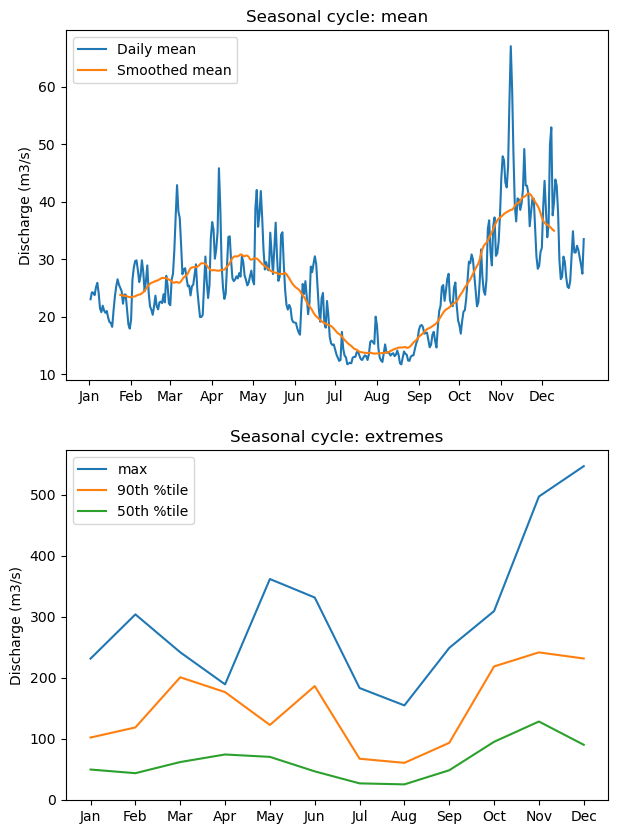

In [ ]:
# plot stats

# day corresponding to first day of each month
# length of months in days
month_lengths = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
# accumulate
month_starts = np.cumsum(month_lengths) - month_lengths

plt.figure
fig, axs = plt.subplots(2, 1, figsize=(7, 10))  # 2 rows, 1 column
xds_stats_clim['daily_means'].plot(ax=axs[0])
xds_stats_clim['smoothed_means'].plot(ax=axs[0])
axs[0].set_title('Seasonal cycle: mean')
axs[0].set_xticks(month_starts)
axs[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[0].legend(['Daily mean', 'Smoothed mean'])
axs[0].set_xlabel('')
axs[0].set_ylabel('Discharge (m3/s)')
# remove day of year from plot

# tx=1
# xds_stats_clim['week_max_p50'].plot(ax=axs[tx])
# xds_stats_clim['week_max_p90'].plot(ax=axs[tx])
# xds_stats_clim['week_max_max'].plot(ax=axs[tx])
# axs[tx].set_title(f'Percentiles of week maxima')
# #axs[tx].set_xticks(np.arange(1, 13, 1))
# #axs[tx].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# axs[tx].legend(['50#tile', '90%tile', 'max'])
# axs[tx].set_xlabel('')
# axs[tx].set_ylabel('Discharge (m3/s)')

tx=1
xds_stats_clim['monthly_max_max'].plot(ax=axs[tx])
xds_stats_clim['monthly_max_p90'].plot(ax=axs[tx])
xds_stats_clim['monthly_max_p50'].plot(ax=axs[tx])

axs[tx].set_title(f'Seasonal cycle of monthly extremes')
axs[tx].set_xticks(np.arange(1, 13, 1))
axs[tx].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[tx].legend(['max','90th %tile', '50th %tile'])
axs[tx].set_xlabel('')
axs[tx].set_ylabel('Discharge (m3/s)')
# legend

# save figure
figname=f"{figdir}/{HazardDef}_seasonal_cycle.png"
plt.savefig(figname)


### Identify extreme events

In [ ]:
def find_events(xdata, prcth, gap=0):
    # INPUT:
    # xdata: xarray of river discharge values (full timeseries)
    # prcth: percentile value to consider as threshold for extreme event detection
    # gap: minimum number of consecutive values below the threshold to consider as a new event

    # OUTPUT:
    # df_events: pandas DataFrame with columns: max_time, max_value, start_time, n_days, values
    # threshold: identified threshold value for event detection

    # data: 1D array of values
    data=xdata.values

    # threshold, threshold value for event detection
    threshold=np.percentile(data, prcth)

    # initialize variables
    events = []        # output list of events
    event_start = None # start index of an event
    event_values = []  # List to store values within each event
    in_event=False

    ierror=0

    # Loop through the data array
    for i, value in enumerate(data):
        if value > threshold:
            if not in_event:
                # Start of a new event
                in_event=True
                #event_start = i
                event_start=xdata['time'].values[i]
            event_values.append(value)
            #print(event_values)
        else:
            # End of an event
            if np.all(data[i:i+gap]<threshold) and in_event: 
                # time of maximum value of event
                event_max_time=np.timedelta64(np.argmax(event_values), 'D')

                # maximum discharge
                event_max=np.max(event_values)

                # length of event
                event_length=len(event_values)

                events.append((event_start+event_max_time, event_max, event_start, event_length, event_values))  # Append the event start and end indices                

                #event_start = None  # Reset event start index
                #event_length = None
                #event_max = None
                #event_max_time = None                
                event_values = []  # Reset event_values    
                in_event=False

            elif np.sum(data[i:i+gap]>=threshold) and in_event:
                event_values.append(value) 

    print(ierror)

    # Convert events to a pandas DataFrame
    df_events = pd.DataFrame(events)
    df_events.columns = ['max_time', 'max_value', 'start_time', 'n_days', 'values']

    # order based on max_value
    df_events.sort_values(by='max_value', ascending=False, inplace=True)

    #event_length=df_events[2].apply(len)
    #event_max=df_events[2].apply(max)
    
    return df_events, threshold


0
Number of events: 205
Discharge threshold for events:  76.1684356689453
      max_time   max_value start_time  n_days  \
185 2020-12-07  546.868408 2020-12-05       9   
176 2019-11-18  497.160980 2019-11-14      22   
198 2023-05-03  361.968628 2023-05-03       4   
200 2023-05-18  344.551392 2023-05-17       7   
13  1994-06-13  331.690002 1994-06-12       7   
..         ...         ...        ...     ...   
93  2010-05-07   77.997681 2010-05-07       1   
114 2013-02-26   77.983871 2013-02-26       1   
68  2007-10-28   77.459229 2007-10-28       1   
150 2016-04-26   76.955139 2016-04-26       1   
202 2023-08-07   76.638168 2023-08-07       1   

                                                values  
185  [118.179375, 455.44354, 546.8684, 226.22144, 1...  
176  [91.435074, 81.651184, 170.31734, 211.84654, 4...  
198        [361.96863, 321.86484, 151.36606, 81.19156]  
200  [149.15546, 344.5514, 243.29083, 122.7341, 110...  
13   [122.141174, 331.69, 259.9074, 199.27698, 139..

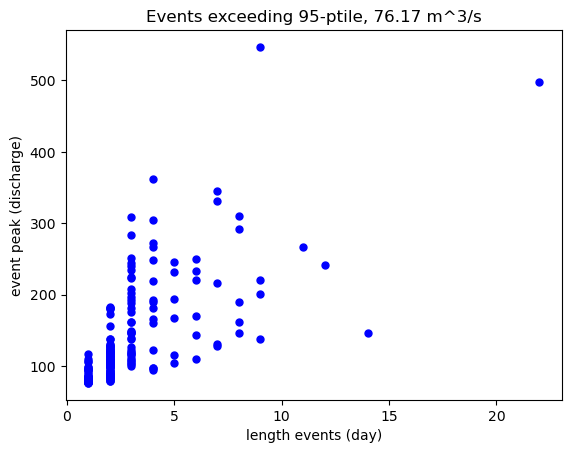

In [19]:

# minimum number of time steps below threshold between independent events. Otherwise it's the same event
if tres=='day':
    steps_independent_event=2
elif tres=='6h':
    steps_independent_event=8

# threshold precentile for event definition (across all timesteps)
prcth=95
df_events,dis_threshold=find_events(xds_hazard['dis24'],prcth,steps_independent_event)

plt.figure
plt.plot(df_events['n_days'],df_events['max_value'],marker='o', linestyle='None', markersize=5, color='blue')
plt.xlabel(f'length events ({tres})')
plt.ylabel('event peak (discharge)')
plt.title(f'Events exceeding {prcth}-ptile, {dis_threshold:,.2f} m^3/s')

# print number of events
print(f"Number of events: {len(df_events)}")
print('Discharge threshold for events: ',dis_threshold)
print(df_events)

# save figure
figname=f"{figdir}/{HazardDef}_events_p{prcth}_peak_vs_duration.png"
fig.savefig(figname)

# save dataframe
filename_events=f"{figdir}/{HazardDef}_events_p{prcth}.xlsx"
df_events.to_excel(filename_events, index=True)  # Requires openpyxl


### Read ERA data

In [ ]:
ERA5dir='/home/zappa/work/ERA5/hourly/'
data_files = {
    ('mean_sea_level_pressure', 'MSL','sfc'),
    ('surface_pressure', 'SP','sfc'),
    ('geopotential','Z','500hPa')
}

years = range(sy, ly+1)

# Loop over each file and variable name
vdata=xr.Dataset()
for variable, variable_name, level_name in data_files:
    if tres=='day':
        erasubdir='day'
        ext=f'day_full_{level_name}_55-55_70_-50_10_55'
        file_paths = f"{ERA5dir}/{variable}/{erasubdir}/ERA5_{variable}_{ext}.nc"
        ds1 = xr.open_dataset(file_paths)
        ds1=ds1.sel(time=slice(str(sy),str(ly)))
    elif tres=='6h':
        erasubdir='6hrs'
        ext=f'6hrs_full_{level_name}_{{year}}_70_-50_10_55'
        file_paths = [f"{ERA5dir}/{variable}/{erasubdir}/ERA5_{variable}_{ext}.nc".format(year=year) for year in years]
        ds1 = xr.open_mfdataset(file_paths,combine='by_coords')

    # convert MSL to hPa
    if variable_name=='MSL':
        ds1['MSL']=ds1['MSL']/100

    vdata=vdata.assign(**{variable_name: ds1[variable_name]})
    del ds1

### Read EMO data and compute area averaged precipitation

In [21]:
import glob

## for each file in EMO1 ending in .nc, read it and save it to a new file with the same name in the new directory
EMO1dir='/home/zappa/work_big/EMO1'

# file name of area-averaged precipitation
precip_basin_fname=f"{EMO1dir}/pr/{watershed}/precip_{watershed}.nc"

# create directory if doesn't exist (considering moving this to the top / and some other directory)
os.makedirs(os.path.dirname(precip_basin_fname), exist_ok=True)

# if exist precip_basin_fname, read it, otherwise compute it
ReadExisting1=True # always read, because rather slow.
if os.path.exists(precip_basin_fname) and ReadExisting1:
    xds_pr_ws_ms=xr.open_dataset(precip_basin_fname)
    print('already processed')
else:
    file_list=glob.glob(f"{EMO1dir}/pr/*.nc")
    print(file_list)        
    xds_emo=xr.open_mfdataset(file_list)
    bbox_lon=slice(bbox[1],bbox[3])
    bbox_lat=slice(bbox[2],bbox[0])
    xds_emo=xds_emo.sel(lon=bbox_lon,lat=bbox_lat)

    ### Average precipitation in watershed
    df_pr_ws,xds_pr_ws=xarray_in_shapefile(xds_emo,'pr','lat','lon',shape_basin_gdf,'mean')

    # convert to totol volume of precip
    sec_in_day=24*3600
    area_m2=shape_basin_gdf['UP_AREA'].values*10**6    # km2 to m2
    # xds_pr_ws_ms=xds_pr_ws['pr']/1000/sec_in_day       # convert mm/day to m/s

    # Copy the dataset to preserve the original data
    xds_pr_ws_ms = xds_pr_ws.copy()

    # Convert precipitation rate to volume in m^3/s
    xds_pr_ws_ms['volume'] = xds_pr_ws['pr'] / 1000 / sec_in_day * area_m2

    # Define the day ranges for accumulation and mean calculations
    day_ranges = [2, 3, 4, 5, 10]

    # Loop through each day range to compute accumulations and means
    for days in day_ranges:
        # Compute volume accumulation over the specified day range
        volume_col_name = f'volume{days}day'
        xds_pr_ws_ms[volume_col_name] = xds_pr_ws_ms['volume'].rolling(time=days).sum()
    
        # Compute mean precipitation rate over the specified day range
        pr_col_name = f'pr{days}day'
        xds_pr_ws_ms[pr_col_name] = xds_pr_ws_ms[volume_col_name] / days * sec_in_day * 1000 / area_m2

    # remove file if exists
    if os.path.exists(precip_basin_fname):
        os.remove(precip_basin_fname)
    xds_pr_ws_ms.to_netcdf(precip_basin_fname, mode='w')


already processed


volume 0 0.2886794136922991
volume -1 0.10865387219441755
volume -2 0.06840201979800184
volume -3 0.052987990869277087
volume -4 0.04891498184438929
volume -5 0.05059601629461921
volume2day 0 0.5654983251432546
volume2day -1 0.24277900275455538
volume2day -2 0.10818508146200424
volume2day -3 0.07417203683405436
volume2day -4 0.06226502060245341
volume2day -5 0.060803442058696026
volume3day 0 0.71823686343134
volume3day -1 0.4823179862089233
volume3day -2 0.21722461922612882
volume3day -3 0.10730280493302562
volume3day -4 0.07944087054002136
volume3day -5 0.07113516838448863
volume4day 0 0.7636914396384173
volume4day -1 0.6401951052145214
volume4day -2 0.42814908329703083
volume4day -3 0.20145215991479853
volume4day -4 0.10835090880794374
volume4day -5 0.08580460165673216
volume5day 0 0.768402506172888
volume5day -1 0.7016267095851769
volume5day -2 0.5805065654809185
volume5day -3 0.3906850648654244
volume5day -4 0.1919422538698005
volume5day -5 0.11145381492155045
maximum correlation: 

Text(0.5, 1.0, 'volume5day precipitation vs peak discharge')

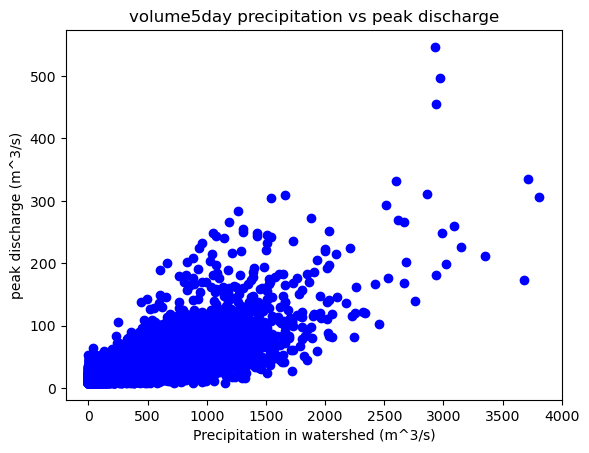

In [22]:
def lag_time_string(time, lag):
    from datetime import datetime, timedelta

    # Convert time_start_plot to a datetime object
    dt = datetime.strptime(time, "%Y-%m-%d")

    # add lag 
    dt += timedelta(days=lag)

    # Convert back to string in the same format
    time = dt.strftime("%Y-%m-%d")
    return time

# function to identify the accumulation of precipitation and lags that maximizes the correlation with the peak discharge
def find_maximum_correlation(xds_precip,xds_hazard,metric,time_start = None, time_end = None, lags=[0]):
    if metric=='volume':
        volume_names=('volume', 'volume2day', 'volume3day', 'volume4day', 'volume5day')
    elif metric=='pr':
        volume_names=('pr', 'pr2day', 'pr3day', 'pr4day', 'pr5day')
    hazard_name='dis24'
    corr_max=0
    vn_max = None
    lag_max = None
    if time_start is not None:
        hazard_ts = xds_hazard[hazard_name].sel(time=slice(time_start, time_end))
    else:
        hazard_ts = xds_hazard[hazard_name]
    for vn in volume_names:
        if time_start is not None:
            precip_ts = xds_precip[vn].sel(time=slice(time_start, time_end))
        else:
            precip_ts = xds_precip[vn]
        for lag in lags:
            # shift precipitation based on lag
            precip_shift=precip_ts.shift(time=lag).fillna(0)
            corr=np.corrcoef(precip_shift.values,hazard_ts.values)[0,1]
            print(vn,lag,corr)
            if corr>corr_max:
                corr_max=corr
                vn_max=vn
                lag_max=lag
    return vn_max, corr_max, lag_max

# scatter of volume precipitation vs peak discharge
time_start_xcorr="1992-01-03"
time_end_xcorr="2022-12-31"
lags=[0, -1, -2, -3, -4, -5]
vol_max, corr_max, lag_max = find_maximum_correlation(xds_pr_ws_ms,xds_hazard,'volume',time_start_xcorr,time_end_xcorr,lags)
print('maximum correlation:',vol_max, corr_max, lag_max)

# set lagged start/end for precip
time_start_volume=lag_time_string(time_start_xcorr,lag_max)
time_end_volume=lag_time_string(time_end_xcorr,lag_max)

volume_np = xds_pr_ws_ms[vol_max].sel(time=slice(time_start_volume, time_end_volume)).values
hazard_np = xds_hazard[disname].sel(time=slice(time_start_xcorr, time_end_xcorr)).values

# Now plot using the NumPy arrays
plt.figure()
plt.scatter(volume_np, hazard_np, marker='o', color='blue')
plt.xlabel('Precipitation in watershed (m^3/s)')
plt.ylabel('peak discharge (m^3/s)')
plt.title(f'{vol_max} precipitation vs peak discharge')

# repeat analysis for tail dependence - only keep days with discharge values above a certain threshold


volume 0 0.263608561036459
volume2day 0 0.7149537875502726
volume3day 0 0.6092924242810731
volume4day 0 0.54605514884065
volume5day 0 0.549191890849417
volume -1 0.7213370343487937
volume2day -1 0.6234966557135779
volume3day -1 0.5480849873115772
volume4day -1 0.5442834847982413
volume5day -1 0.5301240860509284
volume -2 -0.055961239824719664
volume2day -2 -0.07769272450546842
volume3day -2 -0.04357195916515356
volume4day -2 -0.04243413653407786
volume5day -2 -0.028164975005778005
volume -3 -0.11160968264599118
volume2day -3 -0.046258899881557666
volume3day -3 -0.015437909219189395
volume4day -3 0.007928428482977881
volume5day -3 0.0415792236061093
volume -4 -0.025467804855437433
volume2day -4 0.03825975511753505
volume3day -4 0.053984381100934196
volume4day -4 0.08954260541698593
volume5day -4 0.0930040032558967
volume -5 0.09526011839232486
volume2day -5 0.07147975602116094
volume3day -5 0.07813189641787899
volume4day -5 0.07845345548464693
volume5day -5 0.07323573721553468
maximum c

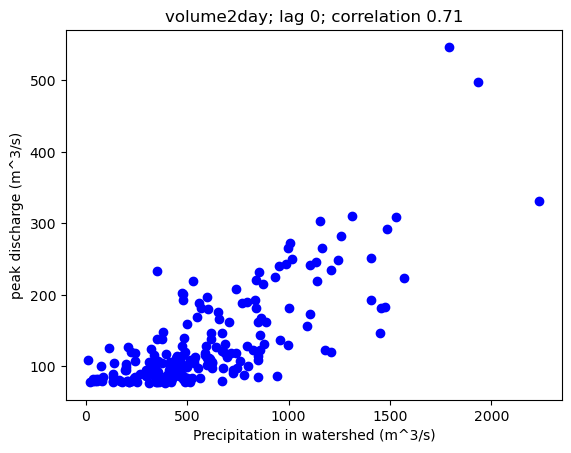

In [23]:
def find_maximum_correlation_events(xds_precip,xds_hazard,events,lags,method):
    from scipy.stats import spearmanr
    volume_names=('volume', 'volume2day', 'volume3day', 'volume4day', 'volume5day')
    hazard_name='dis24'
    corr_max=0
    vn_max = None
    lag_max = None

    # select events
    hazard_ts=xds_hazard[hazard_name].sel(time=events['max_time'].values,method='nearest')
    for lag in lags:
        for vn in volume_names:      
            # shift precipitation based on lag
            precip_shift=xds_precip[vn].sel(time=(events['max_time']+pd.Timedelta(days=lag)).values,method='nearest')
            if method=='spearman':
                corr=spearmanr(precip_shift.values,hazard_ts.values)[0]
            elif method=='pearson':
                corr=np.corrcoef(precip_shift.values,hazard_ts.values)[0,1]
            print(vn,lag,corr)
            # test for relevant increase in maximum correlation
            if corr>corr_max*(1+1/np.sqrt(precip_shift.size)):
                corr_max=corr
                vn_max=vn
                lag_max=lag
    return vn_max, corr_max, lag_max


# subset events based on time range available for both EMO and EFAS
subset_emo=(df_events['max_time']>=time_start_xcorr) & (df_events['max_time']<=time_end_xcorr) 
df_events4emo=df_events[subset_emo]

lags=[0, -1, -2, -3, -4, -5]

# plot for volume
vol_max, corr_max, lag_max = find_maximum_correlation_events(xds_pr_ws_ms,xds_hazard,df_events4emo,lags,'spearman')
print('maximum correlation:',vol_max, corr_max, lag_max)

# plot scatter plot of most correlated variables
xds_hazard_tail=xds_hazard.sel(time=df_events4emo['max_time'].values,method='nearest')
xds_pr_ws_ms_shift=xds_pr_ws_ms.sel(time=(df_events4emo['max_time']+pd.Timedelta(days=lag_max)).values,method='nearest')

plt.figure()
plt.scatter(xds_pr_ws_ms_shift[vol_max].values, xds_hazard_tail[disname].values, marker='o', color='blue')
plt.xlabel('Precipitation in watershed (m^3/s)')
plt.ylabel('peak discharge (m^3/s)')
plt.title(f'{vol_max}; lag {lag_max}; correlation {corr_max:.2f}')

# save figure
figname=f"{figdir}/{HazardDef}_events_p{prcth}_scatter_volume_vs_discharge.png"
plt.savefig(figname)


### Save SLP maps for the events

In [24]:

# order events based on peak intensity
#df_events_sorted=df_events.sort_values(by=3,axis=0,ascending=False)
#df_events_sorted=df_events
#print(df_events_sorted['max_time'].values)

# extract days in ERA5
#vdata_events=vdata.isel(time=df_events_sorted[0]) # this is ok, fix due to missing leap days in era daily
#tref=xds_hazard['time'].isel(time=df_events_sorted['max_time'].values)
#tref=xds_hazard['time'].sel(time=df_events_sorted['max_time'].values)

# quick fix to bring ERA5 daily means (time 09:00) to the same time as EFAS (time 00:00). This is OK since EFAS reflects trasnport over previous 24 hours
vdata1=vdata
vdata1['time'] = vdata['time'] + pd.Timedelta('15H')

# test consider circulation on day before peak discharge
# vdata1['time'] = vdata['time'] - pd.Timedelta('9H')

# extract days in ERA5 associated to peak discharge
vdata_events=vdata1.sel(time=df_events['max_time'].values, method='nearest')


# compute avearged circulation over precipitation events
vdata_events_ave=xr.Dataset()

# 
for i, time in enumerate(vdata_events.time):
    # select average circulation over the typical rainfall period
    time2=time.values
    ndays_event=vol_max[-4:-3]
    if vol_max=='volume':
        time1=time2
    else:        
        time1=time2-np.timedelta64(ndays_event,'D')
    vdata1_ave = vdata1.sel(time=slice(time1,time2)).mean(dim='time')
    vdata1_ave = vdata1_ave.assign_coords(time=time2)

    if i==0:
        vdata_events_ave=vdata1_ave
    else:
        vdata_events_ave=xr.concat([vdata_events_ave, vdata1_ave], dim='time')

/tmp/ipykernel_1853755/3492506658.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  vdata1['time'] = vdata['time'] + pd.Timedelta('15H')


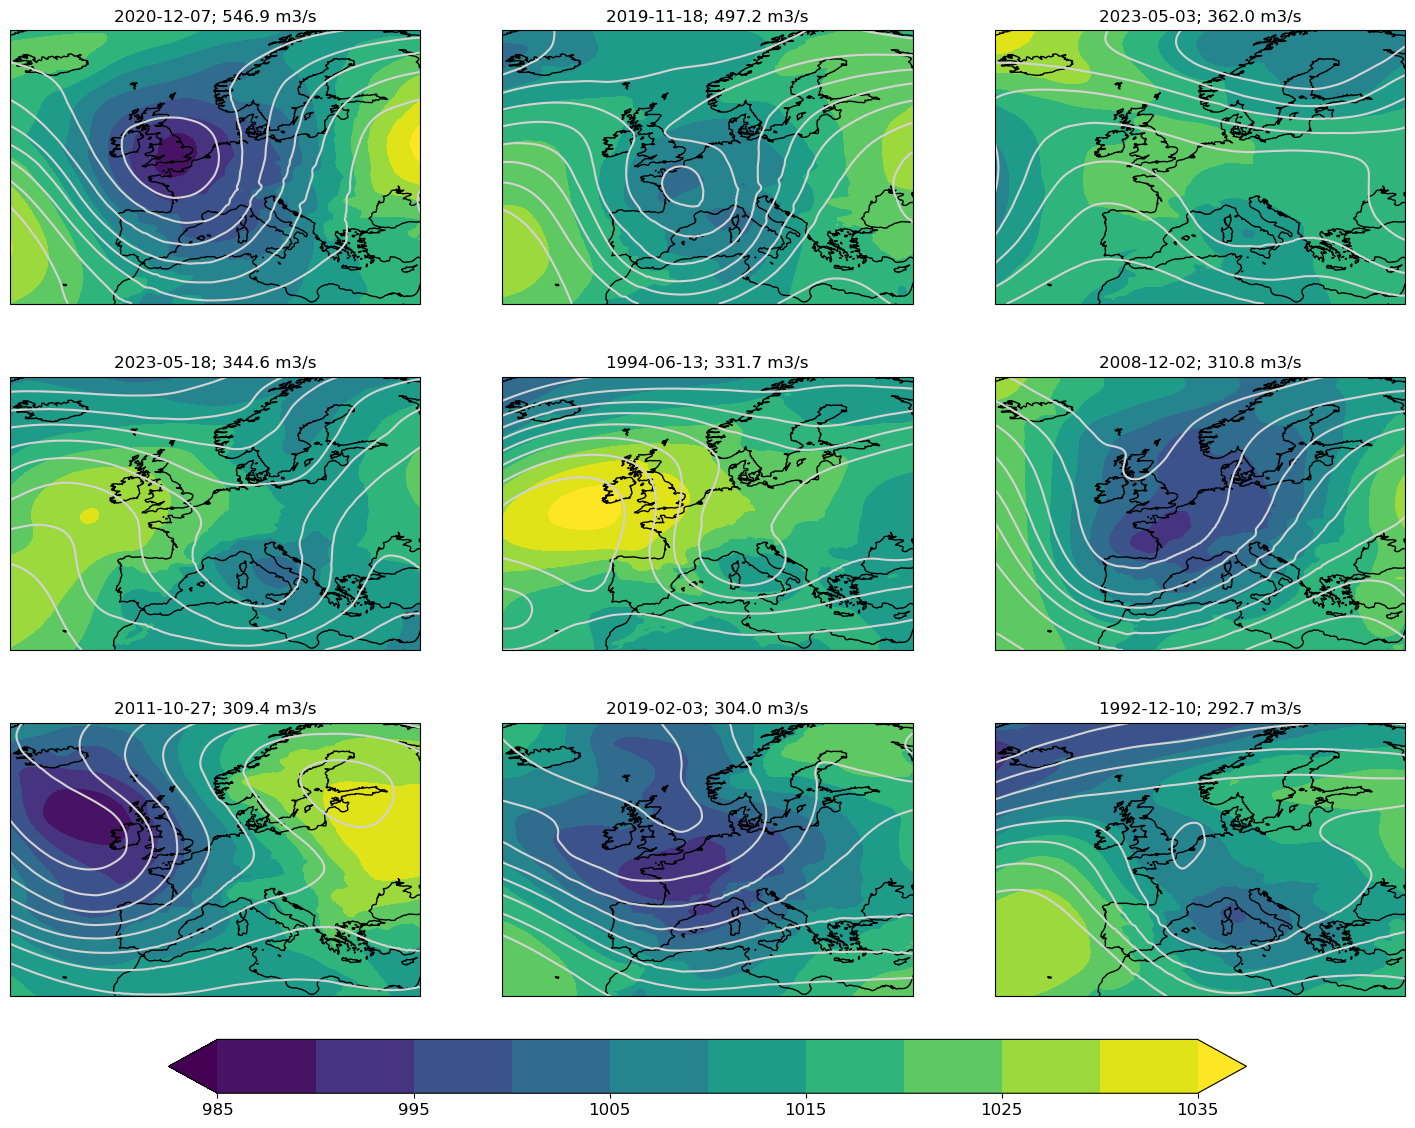

In [25]:

### display map of top 10 events

# plot a subset
max_num_plot=9

# Determine the number of time steps
num_times = max_num_plot

# Calculate the number of rows and columns for the subplot grid
num_rows = int(num_times ** 0.5)
num_cols = (num_times + num_rows - 1) // num_rows

# compute global maximum and minimum values for contour intervals
global_min_MSL = vdata_events.isel(time=slice(0,max_num_plot)).MSL.min(dim=['time', 'lat', 'lon'])
global_max_MSL = vdata_events.isel(time=slice(0,max_num_plot)).MSL.max(dim=['time', 'lat', 'lon'])

# Set uniform contour levels based on global min and max
contour_levels_MSL = np.linspace(985, 1035, num=11)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axes array for easier indexing
axes_flat = axes.flatten()

# Loop through each time step and plot in the corresponding subplot
for i, time in enumerate(vdata_events_ave.isel(time=slice(0,max_num_plot)).time):

    row = i // num_cols
    col = i % num_cols

    # select circulation on day of maximum discharge
    # data_at_time = vdata_events.sel(time=time,lon=slice(-25,35),lat=slice(65,30))
    
    #data_at_time = vdata1.sel(time=time,lon=slice(-25,35),lat=slice(70,30))
    data_at_time = vdata_events_ave.sel(time=time,lon=slice(-25,35),lat=slice(70,30))

    # Set contour levels 
    contour_levels_Z500 = np.linspace(data_at_time.Z.min(), data_at_time.Z.max(), num=10)

    # Plot in the corresponding subplot
    ax = axes[row, col]
    ax.set_title(time.dt.strftime('%Y-%m-%d').item()+'; '+df_events['max_value'].values[i].round(1).astype(str)+' m3/s')
    
    #ax.set_extent([-20, 35, 30, 60], crs=ccrs.PlateCarree())  # Set the desired lat/lon range
    im_MSP = ax.contourf(data_at_time['MSL'].lon, data_at_time['MSL'].lat,
                      data_at_time['MSL'], levels=contour_levels_MSL, cmap='viridis', transform=ccrs.PlateCarree(),extend='both')
    im_Z = ax.contour(data_at_time['Z'].lon, data_at_time['Z'].lat,
                      data_at_time['Z'].sel(plev=50000), levels=contour_levels_Z500, colors='lightgrey', transform=ccrs.PlateCarree())

    # Add coastlines using Cartopy
    ax.coastlines()

# Add color bar at the bottom
cbar = fig.colorbar(im_MSP, ax=axes_flat.tolist(), orientation='horizontal', fraction=0.05, pad=0.04)
cbar.ax.xaxis.set_tick_params(labelsize=12)  # Adjust '10' to your desired font size

# save figure
figname=f"{figdir}/{HazardDef}_map_MSLP_top_events.png"
plt.savefig(figname)

# Show the plots
plt.show()

In [26]:
print(vdata_events_ave)

<xarray.Dataset> Size: 250MB
Dimensions:  (lon: 421, lat: 241, time: 205, plev: 1)
Coordinates:
  * lon      (lon) float64 3kB -50.0 -49.75 -49.5 -49.25 ... 54.5 54.75 55.0
  * lat      (lat) float64 2kB 70.0 69.75 69.5 69.25 ... 10.75 10.5 10.25 10.0
  * plev     (plev) float64 8B 5e+04
  * time     (time) datetime64[ns] 2kB 2020-12-07 2019-11-18 ... 2023-08-07
Data variables:
    MSL      (time, lat, lon) float32 83MB 1.008e+03 1.008e+03 ... 1.011e+03
    SP       (time, lat, lon) float32 83MB 9.383e+04 9.129e+04 ... 1.011e+05
    Z        (time, plev, lat, lon) float32 83MB 5.154e+04 ... 5.776e+04


In [27]:
def composite_events(vdata, df_events):
    era_events=[]
    for event_start in df_events[0]:
        #print(event_start)
        # Extract data for the event time steps
        era_events_tmp = vdata.isel(time=event_start)
        #print(era_events_tmp.dims)
        # Calculate the average of variable B for the event
        era_events.append(era_events_tmp)
    era_events_concatenated = xr.concat(era_events, dim="event") 
    vdata_clim=vdata.mean(dim='time')
    average_era_events = era_events_concatenated.mean(dim="event")
    average_era_events_anom=average_era_events-vdata_clim

    return average_era_events_anom

## List of variable names you want to extract
#ext='6hrs_full_sfc_{year}_70_-50_10_55'
#data_files = {
#    ('surface_pressure', 'SP')
#}
#years = range(1992, 2024)

# compute composite means... commented: a bit slow become of the anomalies
#comp_mean=composite_events(vdata, df_events)
    

In [28]:
# print(comp_mean)
# # Plot composite mean anomaly the variable on the map
# fig = plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Plot the data array
# comp_mean['Z'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# # Add coastlines and gridlines
# ax.coastlines()
# #ax.gridlines()

# # Show the plot
# plt.show()

In [29]:
from collections import Counter

def train_som(data, num_neurons_x=2, num_neurons_y=3, num_epochs=10000):
    # Create a self-organizing map
    som = MiniSom(num_neurons_x, num_neurons_y, data.shape[1], sigma=0.6, learning_rate=0.25)

    # Train the self-organizing map with the provided data
    som.train_random(data, num_epochs)

    # Prediction
    cluster_index = np.array([som.winner(x) for x in data])
    cluster_index = np.ravel_multi_index(cluster_index.T, (num_neurons_x, num_neurons_y))

    return cluster_index, som

def train_som2(xdata, num_neurons_x=2, num_neurons_y=3, num_epochs=10000):

    # weights
    ww=np.sqrt(np.cos(np.radians(xdata['lat'])))
    xdataw=xdata*ww

    # reshape data to give to minisom
    dd4som_v=xdataw.MSL.values
    dd4som_vr=dd4som_v.reshape(dd4som_v.shape[0],-1)

    # Create a self-organizing map
    som = MiniSom(num_neurons_x, num_neurons_y, dd4som_vr.shape[1], sigma=0.5, learning_rate=0.25)

    # Train the self-organizing map with the provided data
    som.train_random(dd4som_vr, num_epochs)

    # get nodes
    wtt=som.get_weights()

    # Prediction
    cluster_index = np.array([som.winner(x) for x in dd4som_vr])
    cluster_index = np.ravel_multi_index(cluster_index.T, (num_neurons_x, num_neurons_y))

    # reshape before output
    wtt=wtt.reshape(num_neurons_x,num_neurons_y,dd4som_v.shape[1],-1)

    # scale nodes back by area weighting --- to do

    return cluster_index, som, wtt

In [30]:
# select data for minisom
dlon_som=slice(-15,30)
dlat_som=slice(60,35)
if watershed=='panaro':
    dlon_som=slice(-15,30)
    dlat_som=slice(60,35)
elif watershed=='lagen':    
    dlon_som=slice(-20,25)
    dlat_som=slice(80,40)
dd4som=vdata_events_ave.sel(lon=dlon_som,lat=dlat_som).squeeze()
nx=1
ny=3
ntop=50 # number of top events to consider from SOM
if ntop>0:
    dd4som=dd4som.isel(time=slice(0,50))
nn=nx*ny
cli, som1, wtt=train_som2(dd4som,nx,ny)


In [31]:
print(dd4som.isel(time=slice(0,50)))

<xarray.Dataset> Size: 11MB
Dimensions:  (lon: 181, lat: 101, time: 50)
Coordinates:
  * lon      (lon) float64 1kB -15.0 -14.75 -14.5 -14.25 ... 29.5 29.75 30.0
  * lat      (lat) float64 808B 60.0 59.75 59.5 59.25 ... 35.75 35.5 35.25 35.0
    plev     float64 8B 5e+04
  * time     (time) datetime64[ns] 400B 2020-12-07 2019-11-18 ... 2021-01-24
Data variables:
    MSL      (time, lat, lon) float32 4MB 1.011e+03 1.01e+03 ... 1.027e+03
    SP       (time, lat, lon) float32 4MB 1.011e+05 1.01e+05 ... 1.026e+05
    Z        (time, lat, lon) float32 4MB 5.222e+04 5.22e+04 ... 5.568e+04


In [32]:
def calculate_threshold(som, data, factor=1.0):
    """
    Calculate a distance threshold based on the standard deviation of the distances from each SOM node to the fields associated with it.

    Parameters:
    som (minisom.MiniSom): The trained SOM.
    data (numpy.ndarray): The data used to train the SOM.
    factor (float): The factor to multiply the standard deviation by to calculate the threshold.

    Returns:
    float: The distance threshold.
    """
    # Get the weights of the SOM
    weights = som.get_weights()

    # Calculate the Euclidean distance from each node to each field
    distances = np.linalg.norm(weights[:, :, np.newaxis] - data, axis=-1)

    # Calculate the standard deviation of the distances
    std_dev = np.std(distances)

    # Calculate the threshold as a multiple of the standard deviation
    threshold = factor * std_dev

    return threshold


def get_winner_within_threshold(som, input_vector, threshold):
    """
    Get the winning node for an input vector if the distance is below a given threshold.

    Parameters:
    som (minisom.MiniSom): The trained SOM.
    input_vector (numpy.ndarray): The input vector.
    threshold (float): The distance threshold.

    Returns:
    tuple: The coordinates of the winning node, or None if no node is within the threshold.
    """
    # Get the weights of the SOM
    weights = som.get_weights()

    # Calculate the Euclidean distance from each node to the input vector
    distances = np.linalg.norm(weights - input_vector, axis=-1)

    # Find the coordinates of the node with the minimum distance
    winning_node = np.unravel_index(distances.argmin(), distances.shape)

    # If the minimum distance is below the threshold, return the coordinates of the winning node
    if distances[winning_node] < threshold:
        return winning_node

    # If no node is within the threshold, return None
    return None

11
[ 987.  991.  995.  999. 1003. 1007. 1011. 1015. 1019. 1023.]


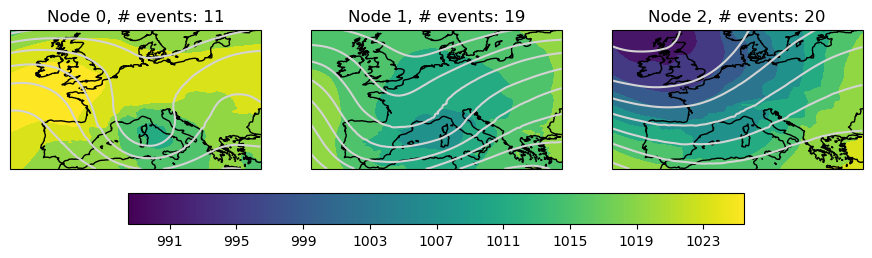

In [33]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FixedLocator


occurrences=Counter(cli)
print(occurrences[0])

# Initialize an empty array to store mean values
mean_node_MSL = np.zeros((4, dd4som.MSL.values.shape[1], dd4som.MSL.values.shape[2]))
mean_node_Z= np.zeros((4, dd4som.Z.values.shape[1], dd4som.Z.values.shape[2]))

unique=np.unique(cli)

mean_node_MSL = [np.mean(dd4som.MSL.values[cli == i,:,:],axis=0) for i in range(0,nn)]
mean_node_Z = [np.mean(dd4som.Z.values[cli == i,:,:],axis=0) for i in range(0,nn)]
std_node_MSL = [np.std(dd4som.MSL.values[cli == i,:,:],axis=0) for i in range(0,nn)]
std_node_Z = [np.std(dd4som.Z.values[cli == i,:,:],axis=0) for i in range(0,nn)]

# Create a Cartopy projection (PlateCarree for geographic data)
projection = ccrs.PlateCarree()

# Create map of mean node
fig_som, axs = plt.subplots(nx, ny, figsize=(11, 8), subplot_kw={'projection': projection})

# Calculate global min and max for d1
global_min_d1 = min([d.min() for d in mean_node_MSL])
global_max_d1 = max([d.max() for d in mean_node_MSL])

# Define levels for contour plot
levels_d1 = np.arange(np.round(global_min_d1-2), np.round(global_max_d1+2), 4)  # Replace min_value_d1, max_value_d1, step_d1 with actual values
print(levels_d1)

for ax, d1, d2, inode in zip(axs.flat, mean_node_MSL, mean_node_Z, range(0,nn)):
    # Plot the data using pcolormesh
    # cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1/100, vmin=global_min_d1, vmax=global_max_d1, transform=projection)
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1, levels_d1, transform=projection,extend='both')

    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, colors='lightgrey', transform=projection)

    # Add coastlines
    ax.coastlines()

    # add number of events
    ax.set_title(f"Node {inode}, # events: {occurrences[inode]}")

    # Add a colorbar
    #cbar = plt.colorbar(cax1,orientation='vertical', fraction=0.05, pad=0.04)

norm = Normalize(vmin=global_min_d1, vmax=global_max_d1)  # Adjust these values based on your data range
smappable = ScalarMappable(norm=norm, cmap=cax1.cmap)  # Use the colormap from your contour plot
cbar = fig_som.colorbar(smappable, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, ticks=levels_d1)
#cbar.set_ticks(FixedLocator(levels_d1))  # Set ticks to match contour levels

# save figure
figname=f"{figdir}/{HazardDef}_events_p{prcth}_ntop{ntop}_map_som_nodes_{nx}x{ny}.png"
fig_som.savefig(figname)

plt.show()


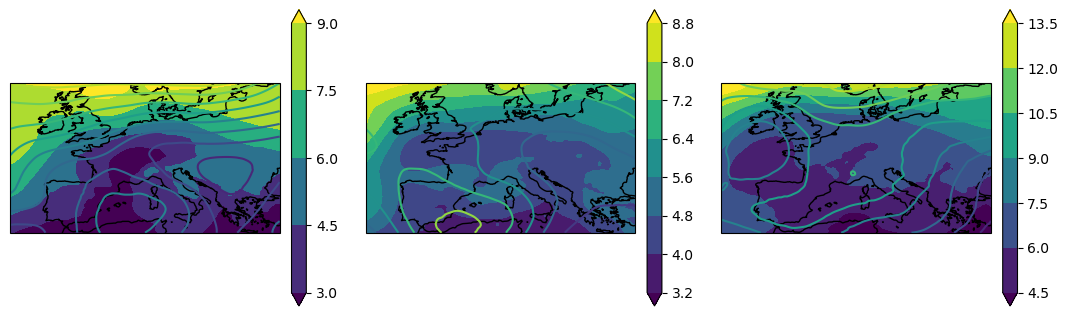

In [34]:


# Create map of std within each node
fig, axs = plt.subplots(nx, ny, figsize=(13, 8), subplot_kw={'projection': projection})

for ax, d1, d2 in zip(axs.flat, std_node_MSL, std_node_Z):
    # Plot the data using pcolormesh
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1, transform=projection, extend='both')
    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, transform=projection)

    # Add coastlines
    ax.coastlines()


    # Create a single colorbar for the figure, using the ScalarMappable
    #cbar = plt.colorbar(ax=cax1, orientation='vertical', fraction=0.05, pad=0.04)

    cbar = plt.colorbar(cax1, orientation='vertical', fraction=0.05, pad=0.04)
plt.show()


In [35]:

# all_transport_per_class = []
# all_time_per_class = []

# # Loop over each inode
# for inode in range(nn):
#     # Filter data for the current inode
#     transport_per_class = df_events.loc[cli == inode, [0, 3]]
#     time_per_class = dd4som.time[cli == inode]

#     # Append the data to the respective lists
#     all_transport_per_class.append(transport_per_class)
#     all_time_per_class.append(time_per_class)


# #plt.plot(all_time_per_class[3].time.values.T)
# inode=3
# plt.plot(all_time_per_class[inode],all_transport_per_class[inode][3],'x')

# # Create a figure and axis for the plot
# plt.figure(figsize=(10, 6))

# # Iterate over all nodes
# for inode in range(len(all_time_per_class)):
#     # Extract the time and transport data for the current inode
#     time_per_class = all_time_per_class[inode]
#     transport_per_class = all_transport_per_class[inode]
    
#     # Plot the occurrences for the current inode
#     plt.scatter(time_per_class, transport_per_class[3], marker='x', label=f'Node {inode}')

# # Add labels and title to the plot
# plt.title('Occurrences of Transport for All Nodes')
# plt.xlabel('Time')
# plt.ylabel('Transport')
# plt.grid(True)
# plt.xticks(rotation=45)


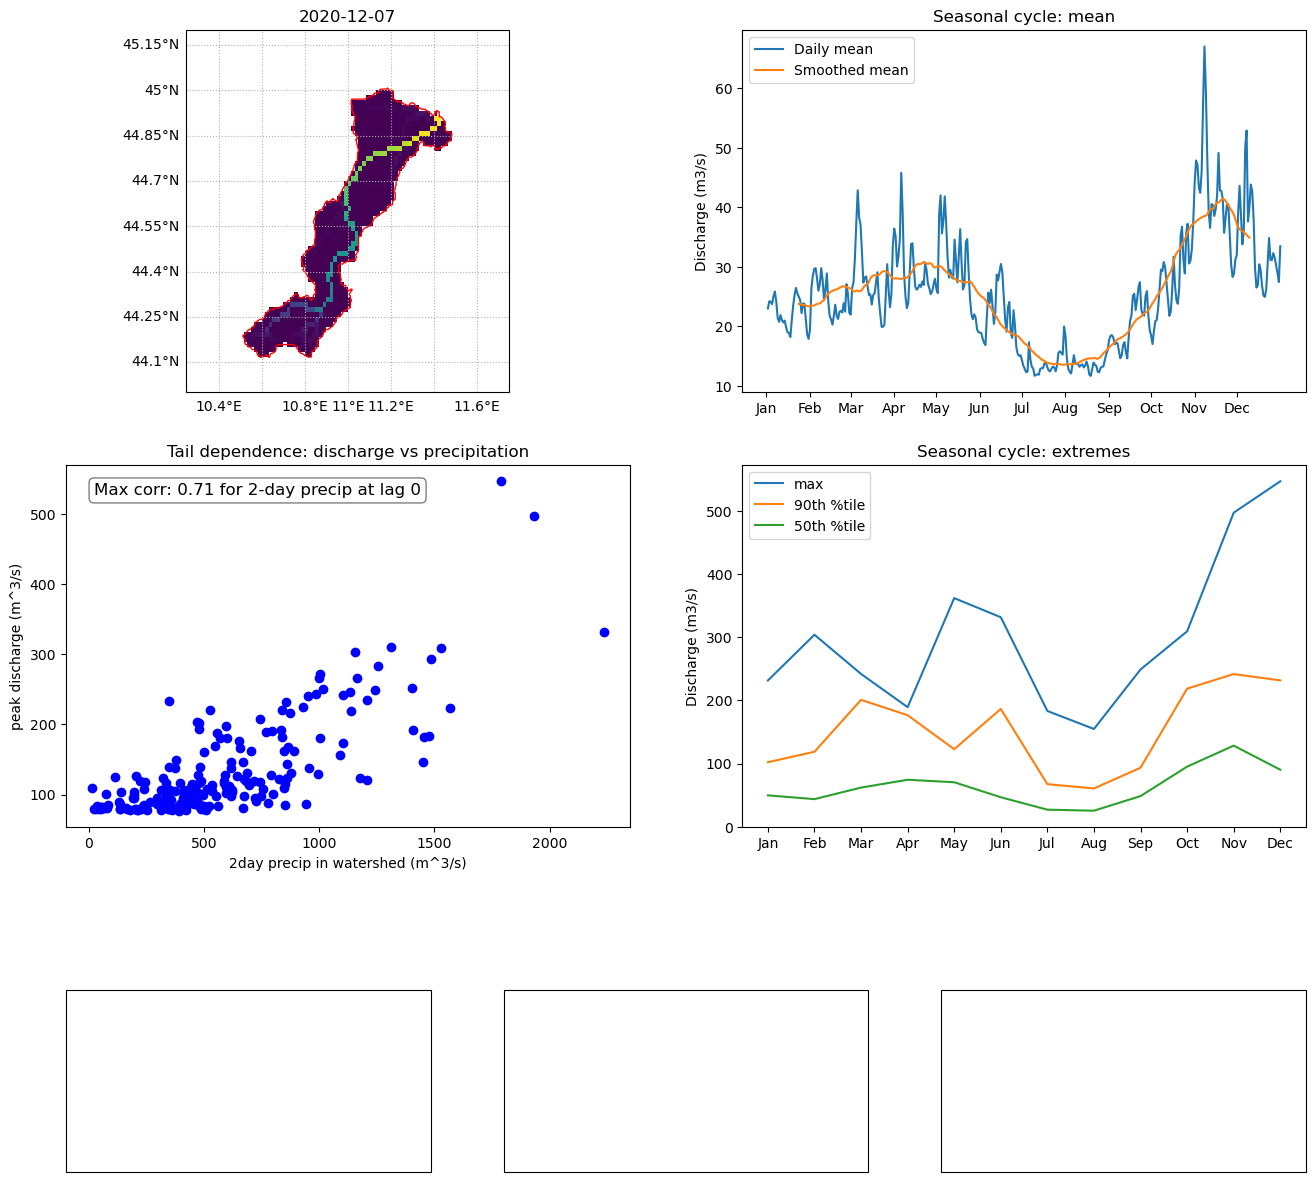

In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 16))
gs_top = gridspec.GridSpec(3, 2, fig)
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_top[2, :])

# Axis 1
ax1 = fig.add_subplot(gs_top[0, 0], projection=ccrs.PlateCarree())
map_discharge(ax1,dataset2d,max_year1,disname,'lon','lat',bbox,shape_basin_gdf)

# Axis 2
ax2 = fig.add_subplot(gs_top[0, 1])
xds_stats_clim['daily_means'].plot(ax=ax2)
xds_stats_clim['smoothed_means'].plot(ax=ax2)
ax2.set_title('Seasonal cycle: mean')
ax2.set_xticks(month_starts)
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.legend(['Daily mean', 'Smoothed mean'])
ax2.set_xlabel('')
ax2.set_ylabel('Discharge (m3/s)')

# Axis 3
ax3 = fig.add_subplot(gs_top[1, 1])
xds_stats_clim['monthly_max_max'].plot(ax=ax3)
xds_stats_clim['monthly_max_p90'].plot(ax=ax3)
xds_stats_clim['monthly_max_p50'].plot(ax=ax3)

ax3.set_title(f'Seasonal cycle: extremes')
ax3.set_xticks(np.arange(1, 13, 1))
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.legend(['max','90th %tile', '50th %tile'])
ax3.set_xlabel('')
ax3.set_ylabel('Discharge (m3/s)')


ax4 = fig.add_subplot(gs_top[1, 0])
plt.scatter(xds_pr_ws_ms_shift[vol_max].values, xds_hazard_tail[disname].values, marker='o', color='blue')
plt.xlabel(f'{vol_max[6:]} precip in watershed (m^3/s)')
plt.ylabel('peak discharge (m^3/s)')
#plt.title(f'{vol_max}; lag {lag_max}; correlation {corr_max:.2f}')
plt.title('Tail dependence: discharge vs precipitation')
# Assuming ax is your subplot axes object and vol_max, lag_max, corr_max are defined
text_str = f'Max corr: {corr_max:.2f} for {vol_max[6:7]}-day precip at lag {lag_max}'
props = dict(boxstyle='round', facecolor='none', alpha=0.5)

# Place the text box in upper left in axes coords
ax4.text(0.05, 0.95, text_str, transform=ax4.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

#plt.delaxes(fig.add_subplot(gs[1, 2]))  # Remove third column for the first row

# # Last row with a subplot spanning both columns
ax5 = fig.add_subplot(gs_bottom[0, 0], projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(gs_bottom[0, 1], projection=ccrs.PlateCarree())
ax7 = fig.add_subplot(gs_bottom[0, 2], projection=ccrs.PlateCarree())


# # Calculate global min and max for d1
# global_min_d1 = min([d.min() for d in mean_node_MSL])
# global_max_d1 = max([d.max() for d in mean_node_MSL])

# # Define levels for contour plot
# levels_d1 = np.arange(np.round(global_min_d1-2), np.round(global_max_d1+2), 4)  # Replace min_value_d1, max_value_d1, step_d1 with actual values
# print(levels_d1)

# for ax, d1, d2, inode in zip(axs.flat, mean_node_MSL, mean_node_Z, range(0,nn)):
#     # Plot the data using pcolormesh
#     # cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1/100, vmin=global_min_d1, vmax=global_max_d1, transform=projection)
#     cax1 = ax5.contourf(dd4som['lon'].values, dd4som['lat'].values, d1, levels_d1, transform=projection,extend='both')
#     cax2 = ax5.contour(dd4som['lon'].values, dd4som['lat'].values, d2, colors='lightgrey', transform=projection)

#     # Add coastlines
#     ax5.coastlines()

#     # add number of events
#     ax5.set_title(f"Node {inode}, # events: {occurrences[inode]}")

#     # Add a colorbar
#     #cbar = plt.colorbar(cax1,orientation='vertical', fraction=0.05, pad=0.04)

# norm = Normalize(vmin=global_min_d1, vmax=global_max_d1)  # Adjust these values based on your data range
# smappable = ScalarMappable(norm=norm, cmap=cax1.cmap)  # Use the colormap from your contour plot
# cbar = fig_som.colorbar(smappable, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, ticks=levels_d1)
# #cbar.set_ticks(FixedLocator(levels_d1))  # Set ticks to match contour levels
# plt.show()

3) Fittare GEV to Annual maxima ... ma con 30 punti ci facciamo poco.... ELENA OK
5) Map tendency of annual maxima (Italy)
6) Composite centered-time evolution of event.
8) Dati di stazione (esistono per panaro) 
10) Medie per stagione / o cluster alla grazzini su TCWV
11) Correlazione con fiumi limitrofi

-> distrubuzioni portate per cluster
-> Serie temporale cluster / portata media per cluster / trend portata per cluster 

-> realismo distribuzione portata forecasts
-> validare la stagionlità portata media
-> PDF aggregata per stagione
-> Distribuzione eventi che ti passano soglia / distribuzione massimi annuali

Correlazione spaziale piene spaziali di EFAS / composite o regressione usando o tutti i giorni o eventi di piena. Piene panaro sono associate a piene altri fiumi? Come cambia in funzione del regime?



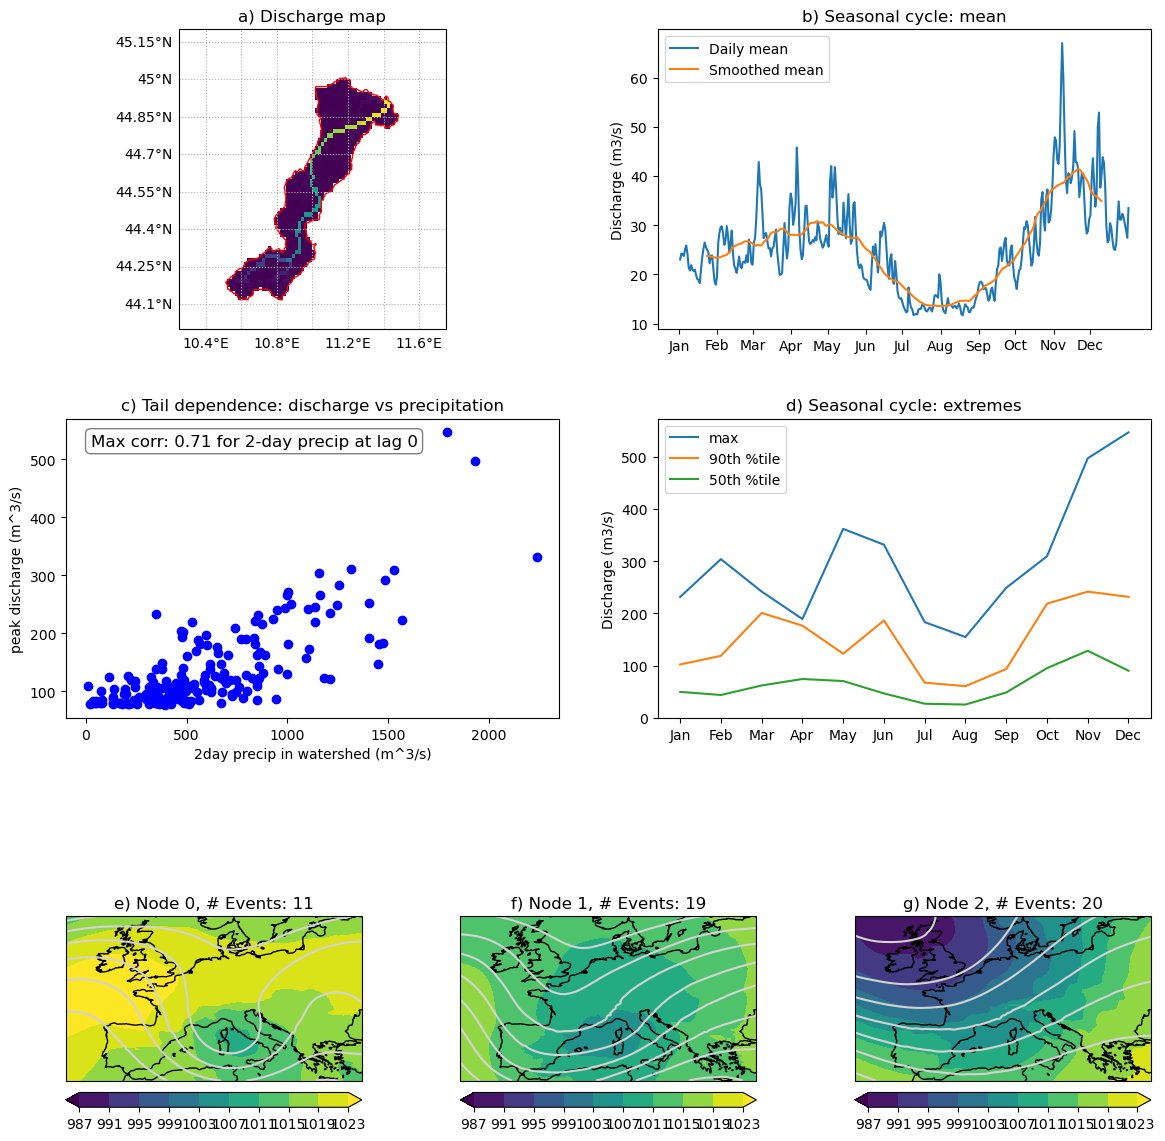

In [37]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(14, 14))

# Define GridSpec
gs = gridspec.GridSpec(3, 6, fig, wspace=1, hspace=0.3)  # Define a grid of 3 rows and 6 columns

# First axis 
ax1 = fig.add_subplot(gs[0, :3], projection=ccrs.PlateCarree())  # Span first 3 columns
map_discharge(ax1,dataset2d,max_year1,disname,'lon','lat',bbox,shape_basin_gdf)
ax1.set_title('a) Discharge map')

# Second axis
ax2 = fig.add_subplot(gs[0, 3:])  # Span last 3 columns
xds_stats_clim['daily_means'].plot(ax=ax2)
xds_stats_clim['smoothed_means'].plot(ax=ax2)
ax2.set_title('b) Seasonal cycle: mean')
ax2.set_xticks(month_starts)
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.legend(['Daily mean', 'Smoothed mean'])
ax2.set_xlabel('')
ax2.set_ylabel('Discharge (m3/s)')

# Third axis
ax3 = fig.add_subplot(gs[1, :3])  # Span first 3 columns
plt.scatter(xds_pr_ws_ms_shift[vol_max].values, xds_hazard_tail[disname].values, marker='o', color='blue')
plt.xlabel(f'{vol_max[6:]} precip in watershed (m^3/s)')
plt.ylabel('peak discharge (m^3/s)')
plt.title('c) Tail dependence: discharge vs precipitation')
text_str = f'Max corr: {corr_max:.2f} for {vol_max[6:7]}-day precip at lag {lag_max}'
props = dict(boxstyle='round', facecolor='none', alpha=0.5)
ax3.text(0.05, 0.95, text_str, transform=ax3.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Fourth axis
ax4 = fig.add_subplot(gs[1, 3:])  # Span last 3 columns
xds_stats_clim['monthly_max_max'].plot(ax=ax4)
xds_stats_clim['monthly_max_p90'].plot(ax=ax4)
xds_stats_clim['monthly_max_p50'].plot(ax=ax4)
ax4.set_title(f'd) Seasonal cycle: extremes')
ax4.set_xticks(np.arange(1, 13, 1))
ax4.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax4.legend(['max','90th %tile', '50th %tile'])
ax4.set_xlabel('')
ax4.set_ylabel('Discharge (m3/s)')


# Third row - three columns, each subplot takes up 2 columns
for d1, d2, inode in zip(mean_node_MSL, mean_node_Z, range(0,nn)):
    if inode==0:
        ax5 = fig.add_subplot(gs[2, :2], projection=ccrs.PlateCarree())  # First 2 columns
        tlab='e)'
    elif inode==1:
        ax5 = fig.add_subplot(gs[2, 2:4], projection=ccrs.PlateCarree())  # Middle 2 columns
        tlab='f)'
    elif inode==2:
        ax5 = fig.add_subplot(gs[2, 4:], projection=ccrs.PlateCarree())  # Last 2 columns
        tlab='g)'

    # Plot the data using pcolormesh
    cax1 = ax5.contourf(dd4som['lon'].values, dd4som['lat'].values, d1, levels_d1, transform=projection,extend='both')
    cax2 = ax5.contour(dd4som['lon'].values, dd4som['lat'].values, d2, colors='lightgrey', transform=projection)

    # Add coastlines
    ax5.coastlines()

    # add number of events
    ax5.set_title(f"{tlab} Node {inode}, # Events: {occurrences[inode]}")

    # Add a colorbar
    cbar = plt.colorbar(cax1,orientation='horizontal', fraction=0.05, pad=0.04)


# norm = Normalize(vmin=global_min_d1, vmax=global_max_d1)  # Adjust these values based on your data range
# smappable = ScalarMappable(norm=norm, cmap=cax1.cmap)  # Use the colormap from your contour plot
# cbar = fig.colorbar(smappable, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, ticks=levels_d1)
# cbar.set_ticks(FixedLocator(levels_d1))  # Set ticks to match contour levels
#plt.show()

# save figure
figname=f"{figdir}/{HazardDef}_D1.3_p{prcth}_ntop{ntop}_{nx}x{ny}.png"
fig.savefig(figname)

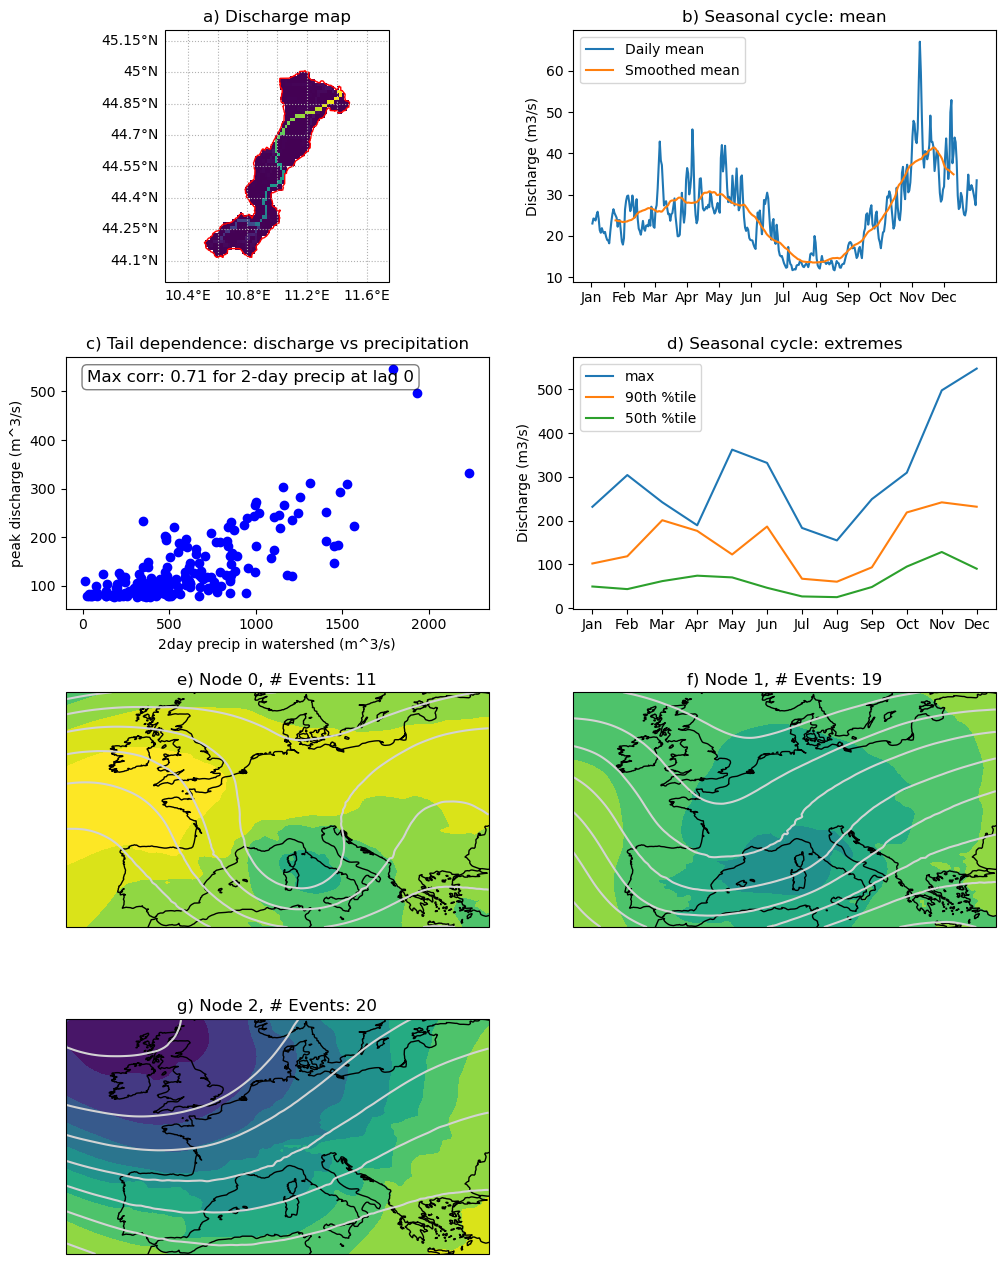

In [38]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(12, 16))
fig.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust the spacing here as needed

# Define the projection
geo_projection = ccrs.PlateCarree()

# Manually add each subplot
# First subplot in each row as a geoaxis
ax1 = fig.add_subplot(4, 2, 1, projection=geo_projection)
ax2 = fig.add_subplot(4, 2, 2)
ax3 = fig.add_subplot(4, 2, 3)
ax4 = fig.add_subplot(4, 2, 4)
ax5 = fig.add_subplot(4, 2, 5, projection=geo_projection)
ax6 = fig.add_subplot(4, 2, 6, projection=geo_projection)
ax7 = fig.add_subplot(4, 2, 7, projection=geo_projection)


# First axis 
map_discharge(ax1,dataset2d,max_year1,disname,'lon','lat',bbox,shape_basin_gdf)
ax1.set_title('a) Discharge map')

# Second axis
xds_stats_clim['daily_means'].plot(ax=ax2)
xds_stats_clim['smoothed_means'].plot(ax=ax2)
ax2.set_title('b) Seasonal cycle: mean')
ax2.set_xticks(month_starts)
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.legend(['Daily mean', 'Smoothed mean'])
ax2.set_xlabel('')
ax2.set_ylabel('Discharge (m3/s)')

# Third axis
ax3.scatter(xds_pr_ws_ms_shift[vol_max].values, xds_hazard_tail[disname].values, marker='o', color='blue')
ax3.set_xlabel(f'{vol_max[6:]} precip in watershed (m^3/s)')
ax3.set_ylabel('peak discharge (m^3/s)')
ax3.set_title('c) Tail dependence: discharge vs precipitation')
text_str = f'Max corr: {corr_max:.2f} for {vol_max[6:7]}-day precip at lag {lag_max}'
props = dict(boxstyle='round', facecolor='none', alpha=0.5)
ax3.text(0.05, 0.95, text_str, transform=ax3.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Fourth axis
xds_stats_clim['monthly_max_max'].plot(ax=ax4)
xds_stats_clim['monthly_max_p90'].plot(ax=ax4)
xds_stats_clim['monthly_max_p50'].plot(ax=ax4)
ax4.set_title(f'd) Seasonal cycle: extremes')
ax4.set_xticks(np.arange(1, 13, 1))
ax4.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax4.legend(['max','90th %tile', '50th %tile'])
ax4.set_xlabel('')
ax4.set_ylabel('Discharge (m3/s)')


# Third row - three columns, each subplot takes up 2 columns
for d1, d2, inode in zip(mean_node_MSL, mean_node_Z, range(0,nn)):
    if inode==0:
        ax=ax5
        tlab='e)'
    elif inode==1:
        ax=ax6
        tlab='f)'
    elif inode==2:
        ax=ax7
        tlab='g)'

    # Plot the data using pcolormesh
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1, levels_d1, transform=projection,extend='both')
    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, colors='lightgrey', transform=projection)

    # Add coastlines
    ax.coastlines()

    # add number of events
    ax.set_title(f"{tlab} Node {inode}, # Events: {occurrences[inode]}")

    # Add a colorbar
    #cbar = plt.colorbar(cax1,orientation='horizontal', fraction=0.05, pad=0.04)


# norm = Normalize(vmin=global_min_d1, vmax=global_max_d1)  # Adjust these values based on your data range
# smappable = ScalarMappable(norm=norm, cmap=cax1.cmap)  # Use the colormap from your contour plot
# cbar = fig.colorbar(smappable, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, ticks=levels_d1)
# cbar.set_ticks(FixedLocator(levels_d1))  # Set ticks to match contour levels
#plt.show()

# save figure
figname=f"{figdir}/{HazardDef}_D1.3_p{prcth}_ntop{ntop}_{nx}x{ny}_test.png"
fig.savefig(figname)

Test role of auto-correlation for annual maxima

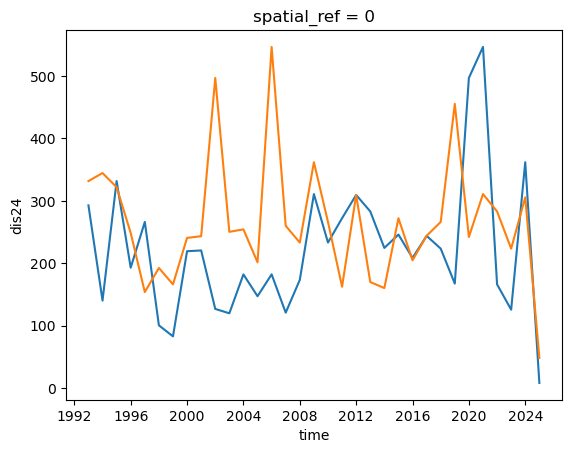

In [51]:


# compute annual maxima
xds_hazard_annual_max=xds_hazard[disname].resample(time='YE').max()
plt.figure()
xds_hazard_annual_max.plot()

# shuffle data
xds_hazard_shuffled=xds_hazard[disname].copy()
xds_hazard_shuffled.values=np.random.permutation(xds_hazard_shuffled.values)
xds_hazard_shuffled_annual_max=xds_hazard_shuffled.resample(time='YE').max()
xds_hazard_shuffled_annual_max.plot()
